# Task 3.1 Construct Dynamic Circuits

**Overview:** This notebook covers how to construct dynamic circuits.

*   **Classical Feed forward and Control Flow** using if statements, multi-bit classical registers and advanced expressions.
*   **Qiskit runtime limitations** with classical control flows.

In [1]:
# Setup: Import necessary libraries
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.classical import expr
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit import transpile

print("Libraries imported successfully.")

Libraries imported successfully.


## Objective : Classical Feedforward and Control Flow

Classical feedforward allows quantum circuits to make decisions based on measurement results, enabling adaptive quantum algorithms where later operations depend on earlier measurement outcomes. A few use cases have been identified like 

- Efficient quantum state prepreation
- Efficient long range entanglement

More information on classical feed forward and dynamic circuits can be found here
https://quantum.cloud.ibm.com/docs/en/guides/classical-feedforward-and-control-flow

### IF Statement with Classical Conditions

The `if_test` method allows conditional operations based on classical register values. This can be used in measurement-based quantum computing, adaptive algorithms and error correction.

An ```else``` block can be added also to ```with``` statement and it is executed when the ```if``` block is not executed.

Dynamic Circuit with Classical Conditional:


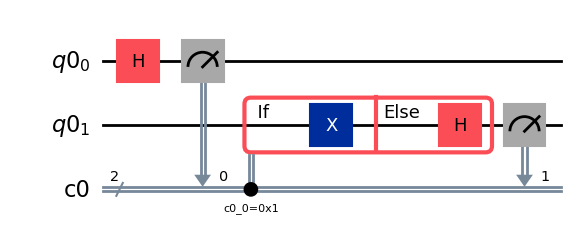

In [2]:
# Create quantum and classical registers
qubits = QuantumRegister(2)
clbits = ClassicalRegister(2)
circuit = QuantumCircuit(qubits, clbits)
(q0,q1) = qubits
(c0,c1) = clbits
 
# Step 1: Create superposition and measure
circuit.h(q0)                    # Apply Hadamard: |0⟩ → (|0⟩ + |1⟩)/√2
circuit.measure(q0, c0)          # Measure qubit and store result in classical bit
 
# Step 2: Conditional operation based on measurement result
with circuit.if_test((c0, 1)) as else_:
    circuit.x(q1)               # X gate is applied on q1 if c0 == 1
with else_:
    circuit.h(q1)               # H gate is applied on q1 if c0 == 0

# Step 3: Measure c1 to see the effect of conditional operation
circuit.measure(q1, c1)

 
print("Dynamic Circuit with Classical Conditional:")
circuit.draw("mpl")
 
# - If first measurement gives |1⟩ (c0=1): X gate applied, second measurement gives c1=1
# - If first measurement gives |0⟩ (c0=0): H gate is applied on q1, c1 has 50% propability of being 1 and 50% of being 0

# Output {'00': 25%, '10': 25%, '11': 50%}

### Multi-bit Classical Register Conditions

The same conditional logic can be applied to classical registers with multiple bits, enabling more complex decision-making based on multi-qubit measurement outcomes.

Dynamic Circuit for multiple bits register


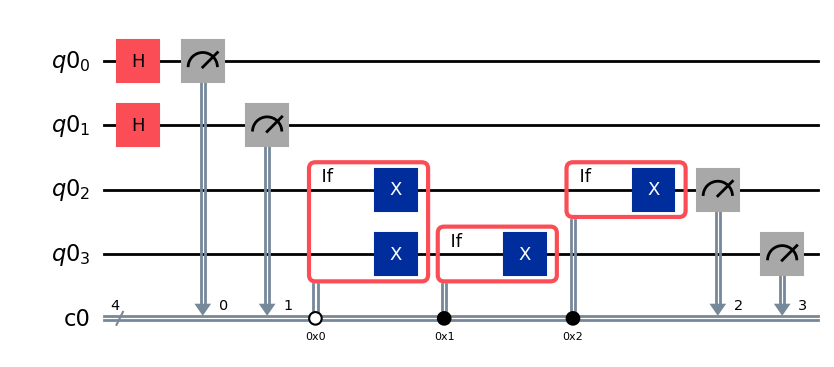

In [2]:
# Create quantum and classical registers
qubits = QuantumRegister(4)
clbits = ClassicalRegister(4)
circuit = QuantumCircuit(qubits, clbits)
(q0,q1,q2,q3) = qubits
(c0,c1,c2,c3) = clbits
 
# Step 1: Create superposition and measure
circuit.h([q0,q1])                 # Apply Hadamard: |00⟩ → (|00⟩ + |01⟩ + |10⟩ + |11⟩)/2
circuit.measure([q0,q1] ,[c0,c1]) # Measure qubits and store result in classical bits
 
# Step 2: Conditional operation based on measurement result
with circuit.if_test((clbits, 0b0000)):
    circuit.x(q2)               # X gate is applied on q2 if c1c0 == 00
    circuit.x(q3)               # x gate is applied on q3 if c1c0 == 00
with circuit.if_test((clbits, 0b0001)):
    circuit.x(q3)               # X gate is applied on q3 if c1c0 == 01    
with circuit.if_test((clbits, 0b0010)):
    circuit.x(q2)               # X gate is applied on q2 if c1c0 == 10
    
    
# Step 3: Measure c1 to see the effect of conditional operation
circuit.measure([q2,q3], [c2,c3])

 
print("Dynamic Circuit for multiple bits register")
circuit.draw("mpl")
 
# - If first measurement gives |00⟩ : X gate applied on q2 and q3, second measurement gives c3c2=11
# - If first measurement gives |01⟩ : X gate applied on q3, second measurement gives c3c2=10
# - If first measurement gives |10⟩ : X gate applied on q2, second measurement gives c3c2=01
# - If first measurement gives |11⟩ : No gate applied, second measurement gives c3c2=00

### Advanced Classical Expressions

Qiskit supports complex classical expressions using the `expr` module, enabling sophisticated conditional logic based on multiple classical bits and their relationships.

In [4]:
# Create registers
qr = QuantumRegister(4, 'q')
cr = ClassicalRegister(3, 'c')   # For first three qubits
cr2 = ClassicalRegister(1, 'c2') # For the fourth qubit
circuit = QuantumCircuit(qr, cr, cr2)

# Create superposition on first three qubits
circuit.h(qr[0])
circuit.h(qr[1])
circuit.h(qr[2])
circuit.measure(qr[0:3], cr)  # Measure first three qubits

# Create complex condition: XOR of all three classical bits
# This checks the parity (even/odd number of 1's)
_condition = expr.bit_xor(expr.bit_xor(cr[0], cr[1]), cr[2])

# Apply X gate to fourth qubit if parity is odd (XOR result is 1)
with circuit.if_test(_condition):
    circuit.x(qr[3])

# Measure the fourth qubit
circuit.measure(qr[3], cr2)

circuit.draw("mpl")

# Execute the circuit to see results
backend = GenericBackendV2(num_qubits=len(circuit.qubits), control_flow=True)
transpiled_circuit = transpile(circuit, backend)
result = backend.run(transpiled_circuit).result()
print("\nMeasurement results:")
print(result.get_counts())


Measurement results:
{'0 011': 124, '1 100': 144, '1 001': 127, '1 010': 129, '0 000': 139, '1 111': 113, '0 110': 114, '0 101': 130, '1 000': 1, '1 011': 2, '0 001': 1}


### Finding backend that support dynamic circuits

Not all backends support dynamic circuits,  The code below checks which backends in your IBM Quantum account support this feature.

In [5]:
# Initialize the service (update credentials if not saved)
# service = QiskitRuntimeService(token="<cloud_api_key>", instance="<instance_CRN>")
service = QiskitRuntimeService()  # Use if credentials are already saved

# Find all backends that support dynamic circuits
dc_backends = service.backends(dynamic_circuits=True)
print("Backends supporting dynamic circuits:")
for backend in dc_backends:
    print(f"- {backend.name}")

Backends supporting dynamic circuits:
- ibm_torino


### Qiskit Runtime Limitations of Classical Control Flow

Important constraints when using classical conditionals in Qiskit:

* **Bit Limit**: Operands in `if_test` statements must be 32 or fewer bits, if you compare a classical register , it has to be less than 32 bits.
* **Broadcasting**: Qiskit Runtime cannot broadcast "transfer data to control logic" more than 60 bits at a time (use barriers to manage different broadcasts).
* **No Nesting**: Nested conditionals (if_test inside another if_test) are not supported.
* **No Reset/Measure in Conditionals**: Reset or measurement operations inside conditionals are not supported.
* **No Arithmetic**: Arithmetic operations within classical expressions are not supported.
* ``` for, while``` and ``` switch``` instructions are not supported.

These limitations are important to consider when designing complex classical feedforward circuits.

---
## Summary
---

In this notebook, we covered:

## Construct Dynamic Circuits:

1. **Use classical feed forward** to control quantum circuits to make decisions based on measurments.
2. **Classical feed forward** can be done using `if_test` and `else` blocks inside `with` statments, and can be done on simple conditions, multi-bit registers or classical expressions.
3. **Qiskit runtime limitations** on control flow include bit limits on operands, broadcasting , nesting, resets, measurments, arithmetic conditions. 


---

## Practice Questions

**1) In the following code snippet, what happens when the first measurement result is 0?**

```
with circuit.if_test((c0, 1)) as else_:
    circuit.x(q1)
with else_:
    circuit.h(q1)
```

A) Both X and H gates are applied to qubit q1

B) Only the X gate is applied to qubit q1

C) Only the H gate is applied to qubit q1

D) No gates are applied to qubit q1



***Answer:***
<Details>

C) Only the H gate is applied to qubit q1
Explanation: When c0 equals 0 (not 1), the else block executes, applying the H gate to q1.
<br/>
</Details>

---

**2) In the following code snippet, what happens when the code is executed?**

```
   cr = ClassicalRegister(60)
   qr = QuantumRegister(60)
   circuit = QuantumCircuit(qr, cr)
   ...
   circuit.measure(qr, cr)
   with circuit.if_test((cr[0], 1)):
      circuit.x(q1)

```

A) X gate is applied on qubit 1

B) X gate is applied on qubit 1 if cr[0] was 1

C) Code does not work as register is more than 32 bits

D) Code does not work as else block is missing



***Answer:***
<Details>
B) X gate is applied on qubit 1 if cr[0] was 1
The code will execute even though the register size is larger than 32 bits, since the comparison is done only on 1 bit
<br/>
</Details>

---

**3) Which answer is NOT a limitation in Qiskit Runtime in regards to dynamic circuits?**

A) Nested If statements

B) Broadcasting more than 60 bits

C) Using arithmetic operations

D) Using logical operations


***Answer:***
<Details>
D) Using logical operations - This is NOT a limitation. Qiskit DOES support logical operations (XOR, AND, OR) 
<br/>
</Details>